## Training DynEdge

Now that both database and selection is ready, everything is in place to begin training. DynEdge is a GNN implemented in GraphNeT - it represents IceCube events as 3D point clouds and leverages techniques from segmentation analysis in computer vision to reconstruct events. You can find technical details on the model in [this paper](https://iopscience.iop.org/article/10.1088/1748-0221/17/11/P11003). The model and training configuration shown below is nearly identical to what's presented in the paper. Note that this configuration was originally meant for low energy, so it's possible that some adjustments might improve performance.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from graphnet.data.constants import FEATURES, TRUTH

from icecube_utils import (
    load_pretrained_model,
    inference, 
    train_dynedge_from_scratch,
    get_acts_wassersteinized_layers_modularized,
    compute_activations_across_models_v1
)
from icecube_utils import make_dataloader
from graphnet.training.labels import Direction
from parameters import get_parser
from train_large import config

features = FEATURES.KAGGLE
truth = TRUTH.KAGGLE

graphnet: INFO     2023-03-04 11:49:02 - get_logger - Writing log to logs/graphnet_20230304-114902.log


/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


graphnet: WARNING  2023-03-04 11:49:04 - warn_once - `icecube` not available. Some functionality may be missing.


In [4]:
# from collections import OrderedDict
# import ot
# import torch
# import numpy as np
# from ground_metric import GroundMetric

# def get_wassersteinized_layers_modularized(args, networks, T_vars_pre_computed=None, activations=None, eps=1e-7, test_loader=None):
#     '''
#     Two neural networks that have to be averaged in geometric manner (i.e. layerwise).
#     The 1st network is aligned with respect to the other via wasserstein distance.
#     Also this assumes that all the layers are either fully connected or convolutional *(with no bias)*

#     :param networks: list of networks
#     :param activations: If not None, use it to build the activation histograms.
#     Otherwise assumes uniform distribution over neurons in a layer.
#     :return: list of layer weights 'wassersteinized', list of transport maps
#     '''

#     # simple_model_0, simple_model_1 = networks[0], networks[1]
#     # simple_model_0 = get_trained_model(0, model='simplenet')
#     # simple_model_1 = get_trained_model(1, model='simplenet')

#     avg_aligned_layers, aligned_layers, T_vars = OrderedDict(), OrderedDict(), OrderedDict()
#     # cumulative_T_var = None
#     T_var = None
#     # print(list(networks[0].parameters()))
#     previous_layer_shape = None
#     ground_metric_object = GroundMetric(args)

#     if args.eval_aligned:
#         model0_aligned_layers = []

#     if args.gpu_id==-1:
#         device = torch.device('cpu')
#     else:
#         device = torch.device('cuda:{}'.format(args.gpu_id))

#     network0_named_parameters = networks[0].named_parameters()
#     network1_named_parameters = networks[1].named_parameters()

#     num_layers = len(list(zip(networks[0].parameters(), networks[1].parameters())))
#     for idx, ((layer0_name, fc_layer0_weight), (layer1_name, fc_layer1_weight)) in \
#             enumerate(zip(network0_named_parameters, network1_named_parameters)):

#         # assert fc_layer0_weight.shape == fc_layer1_weight.shape
#         print("Previous layer shape is ", previous_layer_shape)
#         previous_layer_shape = fc_layer1_weight.shape

#         mu_cardinality = fc_layer0_weight.shape[0]
#         nu_cardinality = fc_layer1_weight.shape[0]

#         # mu = np.ones(fc_layer0_weight.shape[0])/fc_layer0_weight.shape[0]
#         # nu = np.ones(fc_layer1_weight.shape[0])/fc_layer1_weight.shape[0]

#         layer_shape = fc_layer0_weight.shape
#         if len(layer_shape) > 2:
#             is_conv = True
#             # For convolutional layers, it is (#out_channels, #in_channels, height, width)
#             fc_layer0_weight_data = fc_layer0_weight.data.view(fc_layer0_weight.shape[0], fc_layer0_weight.shape[1], -1)
#             fc_layer1_weight_data = fc_layer1_weight.data.view(fc_layer1_weight.shape[0], fc_layer1_weight.shape[1], -1)
#         else:
#             is_conv = False
#             if len(layer_shape) < 2:  # bias
#                 fc_layer0_weight_data = fc_layer0_weight.data[None, :]
#                 fc_layer1_weight_data = fc_layer1_weight.data[None, :]
#                 # fc_layer0_weight_data = fc_layer0_weight.data[:, None]
#                 # fc_layer1_weight_data = fc_layer1_weight.data[:, None]
#             else:
#                 fc_layer0_weight_data = fc_layer0_weight.data
#                 fc_layer1_weight_data = fc_layer1_weight.data

#         print(f'Layer {layer0_name, layer1_name} shape is {fc_layer0_weight_data.shape} and {fc_layer1_weight_data.shape}')

#         if idx == 0:
#             if is_conv:
#                 # M = ground_metric_object.process(fc_layer0_weight_data.view(fc_layer0_weight_data.shape[0], -1),
#                 #                 fc_layer1_weight_data.view(fc_layer1_weight_data.shape[0], -1))
                
#                 M0 = ground_metric_object.process(fc_layer0_weight_data.view(fc_layer0_weight_data.shape[0], -1),
#                                 fc_layer0_weight_data.view(fc_layer0_weight_data.shape[0], -1))
#                 M1 = ground_metric_object.process(fc_layer1_weight_data.view(fc_layer1_weight_data.shape[0], -1),
#                                 fc_layer1_weight_data.view(fc_layer1_weight_data.shape[0], -1))
#                 # M = cost_matrix(fc_layer0_weight_data.view(fc_layer0_weight_data.shape[0], -1),
#                 #                 fc_layer1_weight_data.view(fc_layer1_weight_data.shape[0], -1))
#             else:
#                 # print("layer data is ", fc_layer0_weight_data, fc_layer1_weight_data)
#                 # M = ground_metric_object.process(fc_layer0_weight_data, fc_layer1_weight_data)
#                 M0 = ground_metric_object.process(fc_layer0_weight_data, fc_layer0_weight_data)
#                 M1 = ground_metric_object.process(fc_layer1_weight_data, fc_layer1_weight_data)
#                 # M = cost_matrix(fc_layer0_weight, fc_layer1_weight)

#             aligned_wt = fc_layer0_weight_data
#         else:

#             print("shape of layer: model 0", fc_layer0_weight_data.shape)
#             print("shape of layer: model 1", fc_layer1_weight_data.shape)
#             print("shape of previous transport map", T_var.shape)

#             # aligned_wt = None, this caches the tensor and causes OOM
#             if is_conv:
#                 T_var_conv = T_var.unsqueeze(0).repeat(fc_layer0_weight_data.shape[2], 1, 1)
#                 aligned_wt = torch.bmm(fc_layer0_weight_data.permute(2, 0, 1), T_var_conv).permute(1, 2, 0)

#                 M0 = ground_metric_object.process(
#                     aligned_wt.contiguous().view(aligned_wt.shape[0], -1),
#                     aligned_wt.contiguous().view(aligned_wt.shape[0], -1)
#                 )
#                 M1 = ground_metric_object.process(
#                     fc_layer1_weight_data.view(fc_layer1_weight_data.shape[0], -1),
#                     fc_layer1_weight_data.view(fc_layer1_weight_data.shape[0], -1)
#                 )
#             else:
#                 print(f'fc_layer0_weight_data.shape = {fc_layer0_weight_data.shape}')
#                 print(f'T_var.shape = {T_var.shape}')
#                 # if '_post_processing.0' in layer0_name and 'weight' in layer0_name:
#                 #     temp = [val for name, val in T_vars.items() if 'nn.2.weight' in name]
#                 #     T_var = sum(temp) / len(temp)
#                 #     print(f'T_var.shape = {T_var.shape}')
#                 #     aligned_wt = torch.matmul(fc_layer0_weight_data, T_var)
#                 # el
#                 if 'bias' in layer0_name:
#                     aligned_wt = torch.matmul(fc_layer0_weight_data, T_var).t()
#                 elif fc_layer0_weight_data.shape[1] != T_var.shape[0]:
#                     # Handles the switch from convolutional layers to fc layers
#                     fc_layer0_unflattened = fc_layer0_weight_data.view(fc_layer0_weight.shape[0], T_var.shape[0], -1).permute(2, 0, 1)
#                     aligned_wt = torch.bmm(
#                         fc_layer0_unflattened,
#                         T_var.unsqueeze(0).repeat(fc_layer0_unflattened.shape[0], 1, 1)
#                     ).permute(1, 2, 0)
#                     aligned_wt = aligned_wt.contiguous().view(aligned_wt.shape[0], -1)
                
#                 else:
#                     # print("layer data (aligned) is ", aligned_wt, fc_layer1_weight_data)
#                     aligned_wt = torch.matmul(fc_layer0_weight_data, T_var)
#                 print(f'aligned_wt shape is {aligned_wt.shape}')
#                 print(f'fc_layer1_weight_data shape is {fc_layer1_weight_data.shape}')
#                 # M = cost_matrix(aligned_wt, fc_layer1_weight)
#                 # M = ground_metric_object.process(aligned_wt, fc_layer1_weight_data)
#                 M0 = ground_metric_object.process(aligned_wt, aligned_wt)
#                 M1 = ground_metric_object.process(fc_layer1_weight_data, fc_layer1_weight_data)
#                 # print("ground metric is ", M)
#             if args.skip_last_layer and idx == (num_layers - 1):
#                 print("Simple averaging of last layer weights. NO transport map needs to be computed")
#                 if args.ensemble_step != 0.5:
#                     avg_aligned_layers[layer0_name] = ((1 - args.ensemble_step) * aligned_wt +
#                                           args.ensemble_step * fc_layer1_weight)
#                 else:
#                     avg_aligned_layers[layer0_name] = ((aligned_wt + fc_layer1_weight)/2)
#                 T_vars[layer0_name] = torch.diag(torch.ones(fc_layer1_weight.shape[1]))
#                 aligned_layers[layer0_name] = aligned_wt
#                 return avg_aligned_layers

#         if args.importance is None or (idx == num_layers -1):
#             mu = get_histogram(args, 0, mu_cardinality, layer0_name)
#             nu = get_histogram(args, 1, nu_cardinality, layer1_name)
#         else:
#             # mu = _get_neuron_importance_histogram(args, aligned_wt, is_conv)
#             mu = _get_neuron_importance_histogram(args, fc_layer0_weight_data, is_conv)
#             nu = _get_neuron_importance_histogram(args, fc_layer1_weight_data, is_conv)
#             print(mu, nu)
#             assert args.proper_marginals

#         if 'bias' in layer0_name:
#             pass
#         elif T_vars_pre_computed is None:
#             # cpuM = M.data.cpu().numpy()
#             cpuM0 = M0.data.cpu().numpy()
#             cpuM1 = M1.data.cpu().numpy()
#             print(f'mu shape is {mu.shape}')
#             print(f'nu shape is {nu.shape}')
#             print(f'cpuM0 shape is {cpuM0.shape}')
#             print(f'cpuM1 shape is {cpuM1.shape}')
#             # if args.exact:
#             #     T = ot.emd(mu, nu, cpuM)
#             # else:
#             #     T = ot.bregman.sinkhorn(mu, nu, cpuM, reg=args.reg)
#             # T = ot.emd(mu, nu, log_cpuM)
#             T = ot.gromov.entropic_gromov_wasserstein(cpuM0, cpuM1, mu, nu, loss_fun=args.gromov_loss, epsilon=args.reg)

#             if args.gpu_id!=-1:
#                 T_var = torch.from_numpy(T).cuda(args.gpu_id).float()
#             else:
#                 T_var = torch.from_numpy(T).float()

#             # torch.set_printoptions(profile="full")
#             print("the transport map is ", T_var)
#             # torch.set_printoptions(profile="default")

#             if args.correction:
#                 if not args.proper_marginals:
#                     # think of it as m x 1, scaling weights for m linear combinations of points in X
#                     if args.gpu_id != -1:
#                         # marginals = torch.mv(T_var.t(), torch.ones(T_var.shape[0]).cuda(args.gpu_id))  # T.t().shape[1] = T.shape[0]
#                         marginals = torch.ones(T_var.shape[0]).cuda(args.gpu_id) / T_var.shape[0]
#                     else:
#                         # marginals = torch.mv(T_var.t(),
#                         #                      torch.ones(T_var.shape[0]))  # T.t().shape[1] = T.shape[0]
#                         marginals = torch.ones(T_var.shape[0]) / T_var.shape[0]
#                     marginals = torch.diag(1.0/(marginals + eps))  # take inverse
#                     T_var = torch.matmul(T_var, marginals)
#                 else:
#                     # marginals_alpha = T_var @ torch.ones(T_var.shape[1], dtype=T_var.dtype).to(device)
#                     marginals_beta = T_var.t() @ torch.ones(T_var.shape[0], dtype=T_var.dtype).to(device)

#                     marginals = (1 / (marginals_beta + eps))
#                     print("shape of inverse marginals beta is ", marginals_beta.shape)
#                     print("inverse marginals beta is ", marginals_beta)

#                     T_var = T_var * marginals
#                     # i.e., how a neuron of 2nd model is constituted by the neurons of 1st model
#                     # this should all be ones, and number equal to number of neurons in 2nd model
#                     print(T_var.sum(dim=0))
#                     # assert (T_var.sum(dim=0) == torch.ones(T_var.shape[1], dtype=T_var.dtype).to(device)).all()
#         else:
#             T_var = T_vars_pre_computed[layer0_name]
        
#         if args.debug:
#             if idx == (num_layers - 1):
#                 print("there goes the last transport map: \n ", T_var)
#             else:
#                 print("there goes the transport map at layer {}: \n ".format(idx), T_var)

#             print("Ratio of trace to the matrix sum: ", torch.trace(T_var) / torch.sum(T_var))

#         print("Ratio of trace to the matrix sum: ", torch.trace(T_var) / torch.sum(T_var))
#         print("Here, trace is {} and matrix sum is {} ".format(torch.trace(T_var), torch.sum(T_var)))
#         setattr(args, 'trace_sum_ratio_{}'.format(layer0_name), (torch.trace(T_var) / torch.sum(T_var)).item())

#         if args.past_correction:
#             print("this is past correction for weight mode")
#             print("Shape of aligned wt is ", aligned_wt.shape)
#             print("Shape of fc_layer0_weight_data is ", fc_layer0_weight_data.shape)
#             if 'bias' in layer0_name:
#                 # here, no need to align so as T_var is not changed
#                 t_fc0_model = aligned_wt
#             else:
#                 t_fc0_model = torch.matmul(T_var.t(), aligned_wt.contiguous().view(aligned_wt.shape[0], -1))
#         else:
#             t_fc0_model = torch.matmul(T_var.t(), fc_layer0_weight_data.view(fc_layer0_weight_data.shape[0], -1))

#         # Average the weights of aligned first layers
#         if args.ensemble_step != 0.5:
#             geometric_fc = ((1-args.ensemble_step) * t_fc0_model +
#                             args.ensemble_step * fc_layer1_weight_data.view(fc_layer1_weight_data.shape[0], -1))
#         else:
#             geometric_fc = (t_fc0_model + fc_layer1_weight_data.view(fc_layer1_weight_data.shape[0], -1))/2
#         if is_conv and layer_shape != geometric_fc.shape:
#             geometric_fc = geometric_fc.view(layer_shape)
#         avg_aligned_layers[layer0_name] = (geometric_fc)
#         aligned_layers[layer0_name] = t_fc0_model
#         T_vars[layer0_name] = T_var

#         # get the performance of the model 0 aligned with respect to the model 1
#         if args.eval_aligned:
#             if is_conv and layer_shape != t_fc0_model.shape:
#                 t_fc0_model = t_fc0_model.view(layer_shape)
#             model0_aligned_layers.append(t_fc0_model)
#             _, acc = update_model(args, networks[0], model0_aligned_layers, test=True,
#                                   test_loader=test_loader, idx=0)
#             print("For layer idx {}, accuracy of the updated model is {}".format(idx, acc))
#             setattr(args, 'model0_aligned_acc_layer_{}'.format(str(idx)), acc)
#             if idx == (num_layers - 1):
#                 setattr(args, 'model0_aligned_acc', acc)

#     return avg_aligned_layers, aligned_layers, T_vars

In the cell below, you can choose between training dynedge from scratch on the batch_1 database or loading in a pretrained model that has trained on batches 1 to 50.

In [5]:
config_small = deepcopy(config)
config_small['dynedge']['dynedge_layer_sizes'] = [(128, 256), (336, 256), (336, 256), (336, 256)]

model_small_seed_0 = load_pretrained_model(config=config_small, state_dict_path='/workspace/icecube/weights/dynedge_pretrained_small_0/state_dict.pth')
model_small_seed_1 = load_pretrained_model(config=config_small, state_dict_path='/workspace/icecube/weights/dynedge_pretrained_small_1/state_dict.pth')

In [6]:
# config_large = deepcopy(config)
# config_large['dynedge']['dynedge_layer_sizes'] = [(128 * 2, 256 * 2), (336 * 2, 256 * 2), (336 * 2, 256 * 2), (336 * 2, 256 * 2)]

# model_large = load_pretrained_model(config=config_large, state_dict_path='/workspace/icecube/weights/dynedge_pretrained_large/state_dict.pth')

In [7]:
model_small_seed_0

StandardModel(
  (_detector): IceCubeKaggle(
    (_graph_builder): KNNGraphBuilder()
  )
  (_gnn): DynEdge(
    (_activation): LeakyReLU(negative_slope=0.01)
    (_conv_layers): ModuleList(
      (0): DynEdgeConv(nn=Sequential(
        (0): Linear(in_features=34, out_features=128, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=128, out_features=256, bias=True)
        (3): LeakyReLU(negative_slope=0.01)
      ))
      (1): DynEdgeConv(nn=Sequential(
        (0): Linear(in_features=512, out_features=336, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=336, out_features=256, bias=True)
        (3): LeakyReLU(negative_slope=0.01)
      ))
      (2): DynEdgeConv(nn=Sequential(
        (0): Linear(in_features=512, out_features=336, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=336, out_features=256, bias=True)
        (3): LeakyReLU(negative_slope=0.01)
      ))
      (3):

In [8]:
# model_large

In [9]:
# %%capture --no-stdout
# config_large_random = deepcopy(config_large)
# config_large_random['fit']['max_steps'] = 0
# model_large_random = train_dynedge_from_scratch(config=config_large_random)

In [10]:
# [name for name, _ in model_large_random.named_parameters()]

In [11]:
parser = get_parser()
args = parser.parse_args('--gpu-id 1 --model-name mlpnet --n-epochs 10 --save-result-file sample.csv \
--sweep-name exp_sample --exact --correction --ground-metric euclidean --weight-stats \
--activation-histograms --activation-mode raw --geom-ensemble-type acts --sweep-id 21 \
--act-num-samples 200 --ground-metric-normalize none --activation-seed 21 \
--prelu-acts --recheck-acc --load-models ./mnist_models --ckpt-type final \
--past-correction --not-squared --dist-normalize --print-distances --to-download'.split())

args.gpu_id = 0
args.proper_marginals = True
args.skip_last_layer = True
args.skip_personal_idx = False
args.act_num_samples = 10
args.width_ratio = 1
args.dataset = 'icecube'

In [12]:
train_dataloader = make_dataloader(db = config_small['path'],
    selection = None, # Entire database
    pulsemaps = config_small['pulsemap'],
    features = features,
    truth = truth,
    batch_size = 10,
    num_workers = config_small['num_workers'],
    shuffle = False,
    labels = {'direction': Direction()},
    index_column = config_small['index_column'],
    truth_table = config_small['truth_table'],
)

In [13]:
[x[0] for x in model_small_seed_0.named_parameters()]

['_gnn._conv_layers.0.nn.0.weight',
 '_gnn._conv_layers.0.nn.0.bias',
 '_gnn._conv_layers.0.nn.2.weight',
 '_gnn._conv_layers.0.nn.2.bias',
 '_gnn._conv_layers.1.nn.0.weight',
 '_gnn._conv_layers.1.nn.0.bias',
 '_gnn._conv_layers.1.nn.2.weight',
 '_gnn._conv_layers.1.nn.2.bias',
 '_gnn._conv_layers.2.nn.0.weight',
 '_gnn._conv_layers.2.nn.0.bias',
 '_gnn._conv_layers.2.nn.2.weight',
 '_gnn._conv_layers.2.nn.2.bias',
 '_gnn._conv_layers.3.nn.0.weight',
 '_gnn._conv_layers.3.nn.0.bias',
 '_gnn._conv_layers.3.nn.2.weight',
 '_gnn._conv_layers.3.nn.2.bias',
 '_gnn._post_processing.0.weight',
 '_gnn._post_processing.0.bias',
 '_gnn._post_processing.2.weight',
 '_gnn._post_processing.2.bias',
 '_gnn._readout.0.weight',
 '_gnn._readout.0.bias',
 '_tasks.0._affine.weight',
 '_tasks.0._affine.bias']

In [14]:
{name: x.shape for name, x in model_small_seed_0.named_parameters()}

{'_gnn._conv_layers.0.nn.0.weight': torch.Size([128, 34]),
 '_gnn._conv_layers.0.nn.0.bias': torch.Size([128]),
 '_gnn._conv_layers.0.nn.2.weight': torch.Size([256, 128]),
 '_gnn._conv_layers.0.nn.2.bias': torch.Size([256]),
 '_gnn._conv_layers.1.nn.0.weight': torch.Size([336, 512]),
 '_gnn._conv_layers.1.nn.0.bias': torch.Size([336]),
 '_gnn._conv_layers.1.nn.2.weight': torch.Size([256, 336]),
 '_gnn._conv_layers.1.nn.2.bias': torch.Size([256]),
 '_gnn._conv_layers.2.nn.0.weight': torch.Size([336, 512]),
 '_gnn._conv_layers.2.nn.0.bias': torch.Size([336]),
 '_gnn._conv_layers.2.nn.2.weight': torch.Size([256, 336]),
 '_gnn._conv_layers.2.nn.2.bias': torch.Size([256]),
 '_gnn._conv_layers.3.nn.0.weight': torch.Size([336, 512]),
 '_gnn._conv_layers.3.nn.0.bias': torch.Size([336]),
 '_gnn._conv_layers.3.nn.2.weight': torch.Size([256, 336]),
 '_gnn._conv_layers.3.nn.2.bias': torch.Size([256]),
 '_gnn._post_processing.0.weight': torch.Size([336, 1041]),
 '_gnn._post_processing.0.bias': torc

In [15]:
# import torch

# models = [
#     model_small_seed_0.cuda(),
#     model_large.cuda(), 
# ]
# layer_names = {
#     '_gnn._conv_layers.0.nn.0',
#     '_gnn._conv_layers.0.nn.2',
#     '_gnn._conv_layers.1.nn.0',
#     '_gnn._conv_layers.1.nn.2',
#     '_gnn._conv_layers.2.nn.0',
#     '_gnn._conv_layers.2.nn.2',
#     '_gnn._conv_layers.3.nn.0',
#     '_gnn._conv_layers.3.nn.2',
#     '_gnn._post_processing.0',
#     '_gnn._post_processing.2',
#     '_gnn._readout.0',
#     '_tasks.0._affine',
# }
# with torch.no_grad():
#     activations = compute_activations.compute_activations_across_models_v1(
#         args, 
#         models,
#         train_dataloader,
#         args.act_num_samples,
#         mode=args.activation_mode,
#         layer_names=layer_names
#     )
#     _, model_large_mapped_state_dict = get_acts_wassersteinized_layers_modularized(args, models, activations, train_loader=train_dataloader, test_loader=None)
    
# model_large_mapped = deepcopy(model_large)
# model_large_mapped.load_state_dict(model_large_mapped_state_dict)

In [16]:
import torch

models = [
    model_small_seed_0.cuda(),
    model_small_seed_1.cuda(), 
]
layer_names = {
    '_gnn._conv_layers.0.nn.0',
    '_gnn._conv_layers.0.nn.2',
    '_gnn._conv_layers.1.nn.0',
    '_gnn._conv_layers.1.nn.2',
    '_gnn._conv_layers.2.nn.0',
    '_gnn._conv_layers.2.nn.2',
    '_gnn._conv_layers.3.nn.0',
    '_gnn._conv_layers.3.nn.2',
    '_gnn._post_processing.0',
    '_gnn._post_processing.2',
    '_gnn._readout.0',
    '_tasks.0._affine',
}
with torch.no_grad():
    activations = compute_activations_across_models_v1(
        args, 
        models,
        train_dataloader,
        args.act_num_samples,
        mode=args.activation_mode,
        layer_names=layer_names
    )
    _, model_small_mapped_state_dict, _ = get_acts_wassersteinized_layers_modularized(args, models, activations, train_loader=train_dataloader, test_loader=None)
    
model_small_mapped_state_dict = {
    k: v[:, 0] if 'bias' in k else v for k, v in model_small_mapped_state_dict.items()
}

model_small_mapped = deepcopy(model_small_seed_0)
model_small_mapped.load_state_dict(model_small_mapped_state_dict)

set forward hook for layer named:  _gnn._conv_layers.0.nn.0
set forward hook for layer named:  _gnn._conv_layers.0.nn.2
set forward hook for layer named:  _gnn._conv_layers.1.nn.0
set forward hook for layer named:  _gnn._conv_layers.1.nn.2
set forward hook for layer named:  _gnn._conv_layers.2.nn.0
set forward hook for layer named:  _gnn._conv_layers.2.nn.2
set forward hook for layer named:  _gnn._conv_layers.3.nn.0
set forward hook for layer named:  _gnn._conv_layers.3.nn.2
set forward hook for layer named:  _gnn._post_processing.0
set forward hook for layer named:  _gnn._post_processing.2
set forward hook for layer named:  _gnn._readout.0
set forward hook for layer named:  _tasks.0._affine
set forward hook for layer named:  _gnn._conv_layers.0.nn.0
set forward hook for layer named:  _gnn._conv_layers.0.nn.2
set forward hook for layer named:  _gnn._conv_layers.1.nn.0
set forward hook for layer named:  _gnn._conv_layers.1.nn.2
set forward hook for layer named:  _gnn._conv_layers.2.nn.0

/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:150: UserWarning: An output with one or more elements was resized since it had shape [5082], which does not match the required output shape [847, 6]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:17.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:150: UserWarning: An output with one or more elements was resized since it had shape [30], which does not match the required output shape [10, 3]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, 

graphnet: INFO     2023-03-04 11:49:11 - KNNGraphBuilder.info - WARNING: GraphBuilder received graph with pre-existing structure. Will overwrite.


/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:150: UserWarning: An output with one or more elements was resized since it had shape [6792], which does not match the required output shape [1132, 6]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:17.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


num_personal_idx  0
model_name is  mlpnet
***********
min of act: -1.0750393867492676, max: 1.1964690685272217, mean: -0.09111708402633667
activations for idx 0 at layer _gnn._conv_layers.0.nn.0 have the following shape  torch.Size([1, 6830, 128])
-----------
***********
min of act: -0.7440030574798584, max: 0.847419798374176, mean: -0.06211121752858162
activations for idx 0 at layer _gnn._conv_layers.0.nn.2 have the following shape  torch.Size([1, 6830, 256])
-----------
***********
min of act: -9.220279693603516, max: 10.394956588745117, mean: -0.3689270615577698
activations for idx 0 at layer _gnn._conv_layers.1.nn.0 have the following shape  torch.Size([1, 6776, 336])
-----------
***********
min of act: -10.783872604370117, max: 12.02602481842041, mean: -0.6040855646133423
activations for idx 0 at layer _gnn._conv_layers.1.nn.2 have the following shape  torch.Size([1, 6776, 256])
-----------
***********
min of act: -96.21762084960938, max: 80.86066436767578, mean: -2.31352472305297

<All keys matched successfully>

In [ ]:
activations[0]['_gnn._conv_layers.0.nn.0'].shape

In [ ]:
# _, model_small_mapped_state_dict, T_vars = get_wassersteinized_layers_modularized(
#     args, 
# )
# model_small_mapped = deepcopy(model_small)
# model_small_mapped.load_state_dict(model_small_mapped_state_dict)

# _, model_large_mapped_reverse_state_dict, _ = get_wassersteinized_layers_modularized(
#     args, 
#     [
#         model_small.cuda(), 
#         model_large.cuda()
#     ],
#     T_vars_pre_computed={name: T_var.t() for name, T_var in T_vars.items()}
# )
# model_large_mapped_reverse = deepcopy(model_large)
# model_large_mapped_reverse.load_state_dict(model_large_mapped_reverse_state_dict)

In [ ]:
# _, model_large_mapped_state_dict, _ = get_wassersteinized_layers_modularized(
#     args, 
#     [
#         model_small.cuda(), 
#         model_large.cuda()
#     ],
# )
# model_large_mapped = deepcopy(model_large)
# model_large_mapped.load_state_dict(model_large_mapped_state_dict)

In [ ]:
params = [
    model_small_seed_0.named_parameters(), 
    model_small_seed_1.named_parameters(), 
    model_small_mapped.named_parameters(),
]
for x in zip(*params):
    if 'bias' in x[0][0]:
        continue
    fig, axes = plt.subplots(1, len(params), figsize=(10, 5), sharey=True)
    for i, (name, weight) in enumerate(x):
        axes[i].plot(
            np.arange(weight.shape[0]),
            (
                weight.cuda() @ 
                torch.ones(weight.shape[1])[:, None].cuda()
            ).detach().cpu().numpy()[:, 0]
        )

In [17]:
model_small_seed_0._gnn._conv_layers[0].nn[0].weight[0], \
model_small_mapped._gnn._conv_layers[0].nn[0].weight[0]

(tensor([ 6.1295e-02,  1.1028e-01, -1.1717e-01, -3.8854e-02, -6.2627e-02,
          2.3097e-01, -5.7717e-02, -7.2104e-02,  1.8447e-01, -6.0219e-02,
          1.3923e-01, -1.0745e-01,  1.7164e-01, -4.2805e-02,  5.8988e-02,
          1.4576e-01, -5.9365e-02,  5.2097e-02,  2.4442e-01, -1.2054e-01,
          3.9647e-01, -1.0418e-04,  3.1927e-02,  1.9561e-02, -1.3763e-01,
         -3.0523e-02,  4.5167e-02, -6.8429e-02, -7.5887e-02, -1.2046e-02,
         -1.2525e-01,  6.9123e-02, -1.4175e-01, -1.1680e-01], device='cuda:0',
        grad_fn=<SelectBackward0>),
 tensor([-0.0123,  0.0428, -0.0565,  0.0351,  0.1472,  0.0139, -0.1562, -0.0807,
          0.0852, -0.0071, -0.0167,  0.0178, -0.0693, -0.1542, -0.0742, -0.1493,
         -0.0710, -0.0323,  0.0835, -0.0528,  0.0626,  0.1008,  0.0864,  0.1150,
          0.0855,  0.0448, -0.0193, -0.1187, -0.1466, -0.0647,  0.1000,  0.1513,
         -0.1301,  0.1342], device='cuda:0', grad_fn=<SelectBackward0>))

In [18]:
model_small_seed_0._gnn._conv_layers[0].nn[0].weight[0].shape, \
model_small_mapped._gnn._conv_layers[0].nn[0].weight[0].shape

(torch.Size([34]), torch.Size([34]))

In [21]:
model_small_seed_0._tasks[0]._affine.weight[0], \
model_small_mapped._tasks[0]._affine.weight[0]

(tensor([ 3.6894e-02, -6.8501e-02, -8.0220e-02,  6.9835e-02, -7.4784e-02,
          3.7233e-02,  5.1650e-02,  3.4778e-03, -5.8425e-05,  1.8982e-02,
          7.9133e-02,  6.4829e-02, -4.1147e-02,  3.6530e-02, -7.4932e-02,
         -7.1618e-02,  2.4945e-02,  4.5299e-02, -1.2606e-02,  2.6658e-01,
          5.2291e-02, -6.2747e-03, -5.5356e-02,  2.3704e-02,  2.5280e-02,
          1.2178e-02, -4.0344e-02, -5.6963e-02,  1.6818e-01, -1.1695e-01,
          1.7612e-02,  1.0760e-02,  1.9042e-01,  4.0288e-02, -1.9124e-02,
         -1.0550e-02,  1.1746e-02, -2.6609e-01, -1.0602e-01,  3.9308e-02,
         -4.1234e-02,  2.3099e-01, -2.2672e-02,  2.1830e-02,  1.1472e-01,
         -6.7121e-03, -5.8100e-02, -7.3416e-02, -1.0530e-01, -5.5955e-02,
          3.2086e-01, -1.4910e-01,  8.7975e-03,  2.3983e-02,  1.7895e-01,
         -4.3131e-03,  5.9783e-02,  1.7095e-02, -7.6321e-03, -7.7864e-04,
          6.3382e-03, -3.1748e-02,  5.8793e-02,  1.3729e-03,  3.9562e-02,
          1.4791e-01,  4.6623e-02,  2.

In [23]:
model_small_seed_0._tasks[0]._affine.weight.shape, \
model_small_mapped._tasks[0]._affine.weight.shape

(torch.Size([3, 128]), torch.Size([3, 128]))

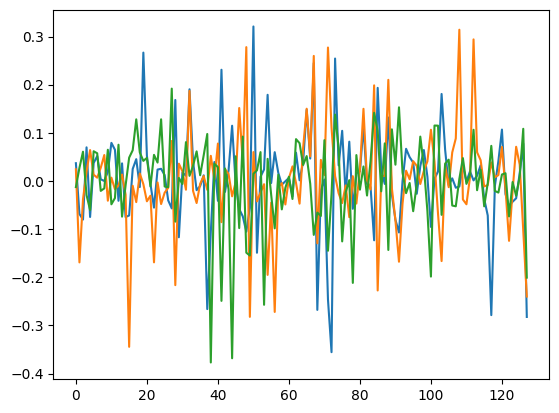

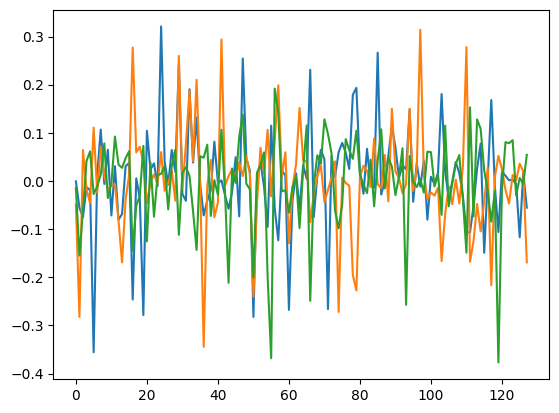

In [28]:
plt.plot(model_small_seed_0._tasks[0]._affine.weight.detach().cpu().numpy().T)
plt.figure()
plt.plot(model_small_mapped._tasks[0]._affine.weight.detach().cpu().numpy().T)

In [ ]:
tol = 1e-5
for idx, ((layer0_name, fc_layer0_weight), (layer1_name, fc_layer1_weight)) in \
        enumerate(zip(model_small_seed_0.named_parameters(), model_small_mapped.named_parameters())):
    with torch.no_grad():
        if not (
            torch.allclose(fc_layer0_weight.mean(), fc_layer1_weight.mean(), rtol=tol, atol=tol) and
            torch.allclose(fc_layer0_weight.abs().mean(), fc_layer1_weight.abs().mean(), rtol=tol, atol=tol) and 
            torch.allclose((fc_layer0_weight.abs() ** 2).mean(), (fc_layer1_weight.abs() ** 2).sum() ** 0.5, rtol=tol, atol=tol)
        ):
            print(layer0_name, fc_layer0_weight.mean(), fc_layer1_weight.mean())

In [ ]:
# with torch.no_grad():
#     model_mapped._gnn._post_processing[0].weight /= 0.5 / 0.7071667
#     model_mapped._gnn._post_processing[2].weight /= 0.5 / 1.0000592
#     model_mapped._gnn._readout[0].weight /= 0.5 / 1.0000384
#     model_mapped._tasks[0]._affine.weight /= 0.7 / 1.0000129

In [15]:
import torch

models = [
    model_small_seed_0.cuda(),
    model_small_seed_1.cuda(), 
    model_small_mapped.cuda(), 
]
layer_names = {
    '_gnn._conv_layers.0.nn.0',
    '_gnn._conv_layers.0.nn.2',
    '_gnn._conv_layers.1.nn.0',
    '_gnn._conv_layers.1.nn.2',
    '_gnn._conv_layers.2.nn.0',
    '_gnn._conv_layers.2.nn.2',
    '_gnn._conv_layers.3.nn.0',
    '_gnn._conv_layers.3.nn.2',
    '_gnn._post_processing.0',
    '_gnn._post_processing.2',
    '_gnn._readout.0',
    '_tasks.0._affine',
}
with torch.no_grad():
    activations = compute_activations.compute_activations_across_models_v1(
        args, 
        models,
        train_dataloader,
        args.act_num_samples,
        mode=args.activation_mode,
        layer_names=layer_names
    )

set forward hook for layer named:  _gnn._conv_layers.0.nn.0
set forward hook for layer named:  _gnn._conv_layers.0.nn.2
set forward hook for layer named:  _gnn._conv_layers.1.nn.0
set forward hook for layer named:  _gnn._conv_layers.1.nn.2
set forward hook for layer named:  _gnn._conv_layers.2.nn.0
set forward hook for layer named:  _gnn._conv_layers.2.nn.2
set forward hook for layer named:  _gnn._conv_layers.3.nn.0
set forward hook for layer named:  _gnn._conv_layers.3.nn.2
set forward hook for layer named:  _gnn._post_processing.0
set forward hook for layer named:  _gnn._post_processing.2
set forward hook for layer named:  _gnn._readout.0
set forward hook for layer named:  _tasks.0._affine
set forward hook for layer named:  _gnn._conv_layers.0.nn.0
set forward hook for layer named:  _gnn._conv_layers.0.nn.2
set forward hook for layer named:  _gnn._conv_layers.1.nn.0
set forward hook for layer named:  _gnn._conv_layers.1.nn.2
set forward hook for layer named:  _gnn._conv_layers.2.nn.0

In [16]:
for acts in zip(*[activations[i].values() for i in range(len(activations))]):
    print(*[a[0].mean(0).mean().cpu().numpy() for a in acts])

-0.091117084 -0.07989494 -0.09111568
-0.062111214 -0.0502208 -0.04657326
-0.36892706 -0.37137255 -0.24844915
-0.60408556 -0.3801384 -0.55235463
-2.313525 -3.190673 -2.062487
-1.4614633 -2.199564 -1.6036091
-2.05151 -4.4359813 -2.044862
-0.855251 -2.2148736 -0.9792863
-3.8216324 -6.9014874 -5.0515547
-4.3128552 -10.041695 -5.1491995
-8.209529 -10.613564 -4.082819
-1.1998192 -6.838935 -0.017566532


In [ ]:
# _gnn._conv_layers.0.nn.0.weight
# _gnn._conv_layers.0.nn.2.weight
# _gnn._conv_layers.1.nn.0.weight
# _gnn._conv_layers.1.nn.2.weight
# _gnn._conv_layers.2.nn.0.weight
# _gnn._conv_layers.2.nn.2.weight
# _gnn._conv_layers.3.nn.0.weight
# _gnn._conv_layers.3.nn.2.weight
# _gnn._post_processing.0.weight 
# _gnn._post_processing.2.weight 
# _gnn._readout.0.weight torch.Si
# _tasks.0._affine.weight torch.S

In [ ]:
for idx, (
    (layer0_name, fc_layer0_weight), 
    (layer1_name, fc_layer1_weight),
) in enumerate(zip(
    model_small_seed_0.named_parameters(), 
    model_small_mapped.named_parameters(),
)):
    with torch.no_grad():
        s1 = (((fc_layer0_weight.abs() ** 2).sum() ** 0.5) / ((fc_layer1_weight.abs() ** 2).sum() ** 0.5)).cpu().numpy()
        print(layer0_name, s1)

In [ ]:
from icecube_utils import make_dataloader
from graphnet.training.labels import Direction

test_dataloader = make_dataloader(db = config_small['inference_database_path'],
    selection = None, # Entire database
    pulsemaps = config_small['pulsemap'],
    features = features,
    truth = truth,
    batch_size = config_small['batch_size'],
    num_workers = config_small['num_workers'],
    shuffle = False,
    labels = {'direction': Direction()},
    index_column = config_small['index_column'],
    truth_table = config_small['truth_table'],
)

In [ ]:
next(iter(test_dataloader))

In [ ]:
from torchviz import make_dot

x = next(iter(test_dataloader)).cpu()
y = model_small_seed_0.cpu()(x)

make_dot(sum(y) / len(y), params=dict(list(model_small_seed_0.named_parameters()))).render("rnn_torchviz", format="png")

In [ ]:
resilts_small_seed_0, resilts_small_seed_1, resilts_small_mapped = [], [], []
for i, batch in enumerate(test_dataloader):
    with torch.no_grad():
        resilts_small_seed_0.append(model_small_seed_0(batch.cuda()))
        resilts_small_seed_1.append(model_small_seed_1(batch.cuda()))
        resilts_small_mapped.append(model_small_mapped.cuda()(batch.cuda()))
    if i > 10:
        break

In [ ]:
for a, b, c in zip(resilts_small_seed_0, resilts_small_seed_1, resilts_small_mapped):
    print(
        (np.abs(a[0].cpu().numpy()) ** 2).sum() ** 0.5, 
        (np.abs(b[0].cpu().numpy()) ** 2).sum() ** 0.5,
        (np.abs(c[0].cpu().numpy()) ** 2).sum() ** 0.5,
    )

## Inference & Evaluation

With a trained model loaded into memory, we can now apply the model to batch_51. The following cells will start inference (or load in a csv with predictions, if you're in a hurry) and plot the results. 

In [30]:
def convert_to_3d(df: pd.DataFrame) -> pd.DataFrame:
    """Converts zenith and azimuth to 3D direction vectors"""
    df['true_x'] = np.cos(df['azimuth']) * np.sin(df['zenith'])
    df['true_y'] = np.sin(df['azimuth']) * np.sin(df['zenith'])
    df['true_z'] = np.cos(df['zenith'])
    return df

def calculate_angular_error(df : pd.DataFrame) -> pd.DataFrame:
    """Calcualtes the opening angle (angular error) between true and reconstructed direction vectors"""
    df['angular_error'] = np.arccos(df['true_x']*df['direction_x'] + df['true_y']*df['direction_y'] + df['true_z']*df['direction_z'])
    return df

In [31]:
%%capture --no-stdout
df = calculate_angular_error(convert_to_3d(inference(model_small_seed_0, config_small))) 
df.to_hdf('results/small_0.h5', key='df', mode='w')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2000/2000 [02:20<00:00, 14.26it/s]
graphnet: INFO     2023-03-04 11:24:21 - inference - Writing results to training/train_model_without_configs/batch_1/dynedge_direction_my_example


In [32]:
%%capture --no-stdout
df = calculate_angular_error(convert_to_3d(inference(model_small_seed_1, config_small))) 
df.to_hdf('results/small_1.h5', key='df', mode='w')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2000/2000 [02:21<00:00, 14.12it/s]
graphnet: INFO     2023-03-04 11:27:14 - inference - Writing results to training/train_model_without_configs/batch_1/dynedge_direction_my_example


In [ ]:
# %%capture --no-stdout
# df = calculate_angular_error(convert_to_3d(inference(model_large, config_large)))
# df.to_hdf('results/large.h5', key='df', mode='w')

In [ ]:
# %%capture --no-stdout
# df = calculate_angular_error(convert_to_3d(inference(model_large_random, config_large_random)))
# df.to_hdf('results/large_random.h5', key='df', mode='w')

In [ ]:
# %%capture --no-stdout
# df = calculate_angular_error(convert_to_3d(inference(model_large_mapped, config_large)))
# df.to_hdf('results/large_mapped.h5', key='df', mode='w')

In [34]:
%%capture --no-stdout
df = calculate_angular_error(convert_to_3d(inference(model_small_mapped, config_small)))
df.to_hdf('results/mapped_gromov.h5', key='df', mode='w')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2000/2000 [02:20<00:00, 14.19it/s]
graphnet: INFO     2023-03-04 11:31:37 - inference - Writing results to training/train_model_without_configs/batch_1/dynedge_direction_my_example


In [35]:
results = {
    'small_0': pd.read_hdf('results/small_0.h5', key='df'),
    'small_1': pd.read_hdf('results/small_1.h5', key='df'),
    'mapped_gromov': pd.read_hdf('results/mapped_gromov.h5', key='df'),
}

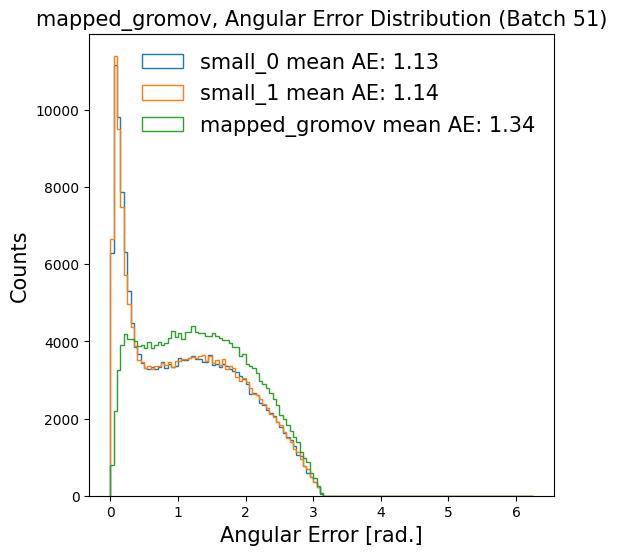

In [36]:
fig = plt.figure(figsize = (6,6))
for name, result in results.items():
    plt.hist(result['angular_error'], 
            bins = np.arange(0,np.pi*2, 0.05), 
            histtype = 'step', 
            label = f'{name} mean AE: {np.round(result["angular_error"].mean(),2)}')
    plt.xlabel('Angular Error [rad.]', size = 15)
    plt.ylabel('Counts', size = 15)
plt.title(f'{name}, Angular Error Distribution (Batch 51)', size = 15)
plt.legend(frameon = False, fontsize = 15)

So the pre-trained dynedge seems to perform quite well. Another interesting feature of the reconstruction is that dynedge (when coupled with the[ DirectionReconstructionWithKappa](https://github.com/graphnet-team/graphnet/blob/7e857562898ebebebc9a105159fd3d4eb4994aea/src/graphnet/models/task/reconstruction.py#L45) is that dynedge estimated *kappa* the concentration parameter from the vonMisesFisher distribution. Kappa is analogus to sigma via sigma = 1/sqrt(kappa), and the quality of the direction estimate should be highly correlated with this parameter. 

In [ ]:
cut_threshold = 0.5
for name, result in results.items():
    fig = plt.figure(figsize = (6,6))
    plt.hist(result['angular_error'][1/np.sqrt(result['direction_kappa']) <= cut_threshold], 
            bins = np.arange(0,np.pi*2, 0.05), 
            histtype = 'step', 
            label = f'sigma <= {cut_threshold}: {np.round(result["angular_error"][1/np.sqrt(result["direction_kappa"]) <= cut_threshold].mean(),2)}')

    plt.hist(result['angular_error'][1/np.sqrt(result['direction_kappa']) > cut_threshold], 
            bins = np.arange(0,np.pi*2, 0.05), 
            histtype = 'step', 
            label = f'sigma > {cut_threshold}: {np.round(result["angular_error"][1/np.sqrt(result["direction_kappa"]) > cut_threshold].mean(),2)}')
    plt.xlabel('Angular Error [rad.]', size = 15)
    plt.ylabel('Counts', size = 15)
    plt.title(f'{name}, Angular Error Distribution (Batch 51)', size = 15)
    plt.legend(frameon = False, fontsize = 15)

As you can see, the variable can be used to distinguish "good" and "bad" reconstructions with some confidence. 

## A few hints for your neutrino data science journey!

* The configuration of dynedge shown in this notebook is the so-called "baseline". It's not optimized for high energy neutrinos, so you might be able to squeeze out a bit more performance by tuning hyperparameters or making larger modifications; such as switching out the learning rate scheduler or choosing a different loss function, etc.

* You can use the kappa variable to group events into different categories. Perhaps training a seperate reconstruction method for each performs better?

* You may want to adjust the [ParquetDataset](https://github.com/graphnet-team/graphnet/blob/7e857562898ebebebc9a105159fd3d4eb4994aea/src/graphnet/data/parquet/parquet_dataset.py#L11) such that it works with the competition data. This would allow you to train / infer directly on the competition files (No conversion to sqlite needed). Feel free to contribute this to the repository!


Good luck!